In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix 

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

In [4]:
# get data and resize image
def get_data(data_dir, labels):
    data=[]
    for label in labels: 
        path = os.path.join(data_dir, label)
        index_label = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resize_img_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resize_img_arr, index_label])
            except Exception as e:
                print(e)
    return data 

### Load Dataset

In [5]:
data_train = get_data('../input/chest_xray/train', labels)
data_test = get_data('../input/chest_xray/test', labels)


In [6]:
print(f'Data Train: {len(data_train)}')
print(f'Data Test: {len(data_test)}')
print(f'Total data = {len(data_train) + len(data_test)}')

Data Train: 5216
Data Test: 624
Total data = 5840


## Data Visualization

<AxesSubplot:xlabel='count'>

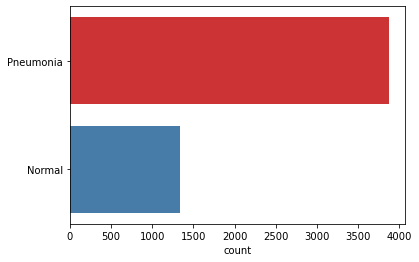

In [7]:
data_count = []
for data in data_train:
    if(data[1] == 0):
        data_count.append('Pneumonia')
    else:
        data_count.append('Normal')

sns.countplot(y=data_count, palette="Set1")

Text(0.5, 1.0, 'NORMAL')

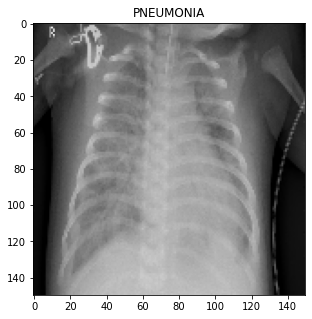

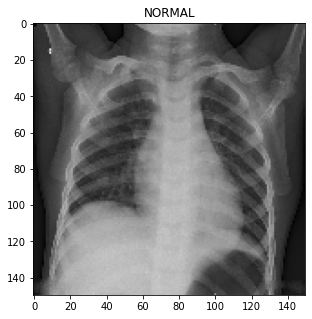

In [8]:
plt.figure(figsize=(5,5))
plt.imshow(data_train[0][0], cmap="gray")
plt.title(labels[data_train[0][1]])

plt.figure(figsize=(5,5))
plt.imshow(data_train[-1][0], cmap="gray")
plt.title(labels[data_train[-1][-1]])


In [9]:
X_train = []
X_test = []

y_train = []
y_test = []

for feature, label in data_train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in data_test:
    X_test.append(feature)
    y_test.append(label)


In [10]:
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

In [11]:
# resize data for deep learning
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)

y_train = np.array(y_train)
y_test = np.array(y_test)

### Data Augmentation

In [12]:
# documentation https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=30,
        zoom_range=0.3,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)

datagen.fit(X_train)

## Training Model


In [13]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=[img_size, img_size, 1]))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [14]:
epochs = 20
optimizer = 'adam'

In [15]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(datagen.flow(X_train,
                     y_train, batch_size=32), 
                    epochs=epochs,
                    validation_data=(X_test, y_test))

Epoch 1/20
163/163 [==============================] - 11s 50ms/step - loss: 0.5909 - accuracy: 0.7425 - val_loss: 0.5772 - val_accuracy: 0.6731
Epoch 2/20
163/163 [==============================] - 8s 49ms/step - loss: 0.3735 - accuracy: 0.8359 - val_loss: 0.3437 - val_accuracy: 0.8478
Epoch 3/20
163/163 [==============================] - 8s 48ms/step - loss: 0.3022 - accuracy: 0.8668 - val_loss: 0.3366 - val_accuracy: 0.8462
Epoch 4/20
163/163 [==============================] - 8s 48ms/step - loss: 0.2752 - accuracy: 0.8846 - val_loss: 0.3375 - val_accuracy: 0.8654
Epoch 5/20
163/163 [==============================] - 8s 48ms/step - loss: 0.2285 - accuracy: 0.9049 - val_loss: 0.3654 - val_accuracy: 0.8750
Epoch 6/20
163/163 [==============================] - 8s 48ms/step - loss: 0.2290 - accuracy: 0.9072 - val_loss: 0.4328 - val_accuracy: 0.8526
Epoch 7/20
163/163 [==============================] - 8s 48ms/step - loss: 0.2048 - accuracy: 0.9187 - val_loss: 0.2864 - val_accuracy: 0.886

## Analysis Model

In [16]:
evaluate_loss = model.evaluate(X_test, y_test)[0]
evaluate_accuracy = model.evaluate(X_test, y_test)[1]*100
print(f'Loss Model: {evaluate_loss}')
print(f'Accuracy Model: {evaluate_accuracy} %')

20/20 [==============================] - 0s 9ms/step - loss: 0.3311 - accuracy: 0.8974
Loss Model: 0.3311038017272949
Accuracy Model: 89.74359035491943 %


In [17]:
epochs_range = [i for i in range(epochs)]

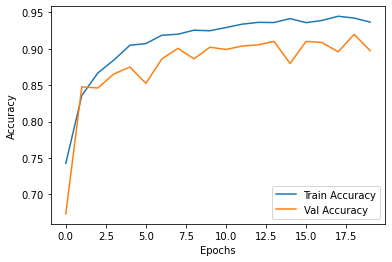

In [43]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs_range, accuracy, label='Train Accuracy')
plt.plot(epochs_range, val_accuracy, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

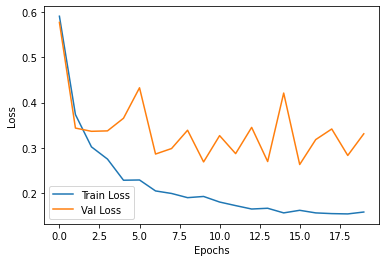

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower left')

plt.show()

In [36]:
predic_x = model.predict(X_test)
predictions = np.argmax(predic_x, axis=1)
predictions = predictions.reshape(1,-1)[0]
predictions[-15:]


20/20 [==============================] - 0s 9ms/step


array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1], dtype=int64)

In [40]:
import itertools

def plot_confusion_matrix(confusion_matr, 
                        classes,
                        normalize=False,
                        title="Confusion Matrix",
                        cmap=plt.cm.Blues):
    plt.imshow(confusion_matr, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = confusion_matr.max() / 2.
    for i, j in itertools.product(range(confusion_matr.shape[0]),
                                    range(confusion_matr.shape[1])):
        plt.text(j, i, confusion_matr[i, j],
        horizontalalignment='center',
        color='white' if confusion_matr[i, j] > thresh else 'black')
    plt.tight_layout()
 

In [41]:
cf_matrix = confusion_matrix(y_test, predictions)
cf_matrix

array([[386,   4],
       [ 60, 174]], dtype=int64)

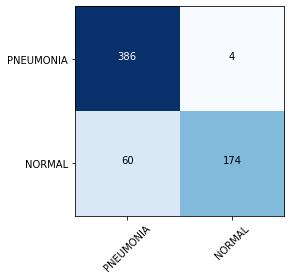

In [42]:
plot_confusion_matrix(cf_matrix, labels, title='')

## Save Model

In [39]:
model.save(os.getcwd() + "/mModel")

INFO:tensorflow:Assets written to: e:\Kuliah\Semester 6\Kecerdasan Buatan\tugas-kelompok/mModel\assets


INFO:tensorflow:Assets written to: e:\Kuliah\Semester 6\Kecerdasan Buatan\tugas-kelompok/mModel\assets
